In [4]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import math
from tqdm.autonotebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = colors.ListedColormap(['white', 'crimson', 'green'])
bounds=np.array([0,1,2, 3])
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.style.use('ncb.mplstyle')

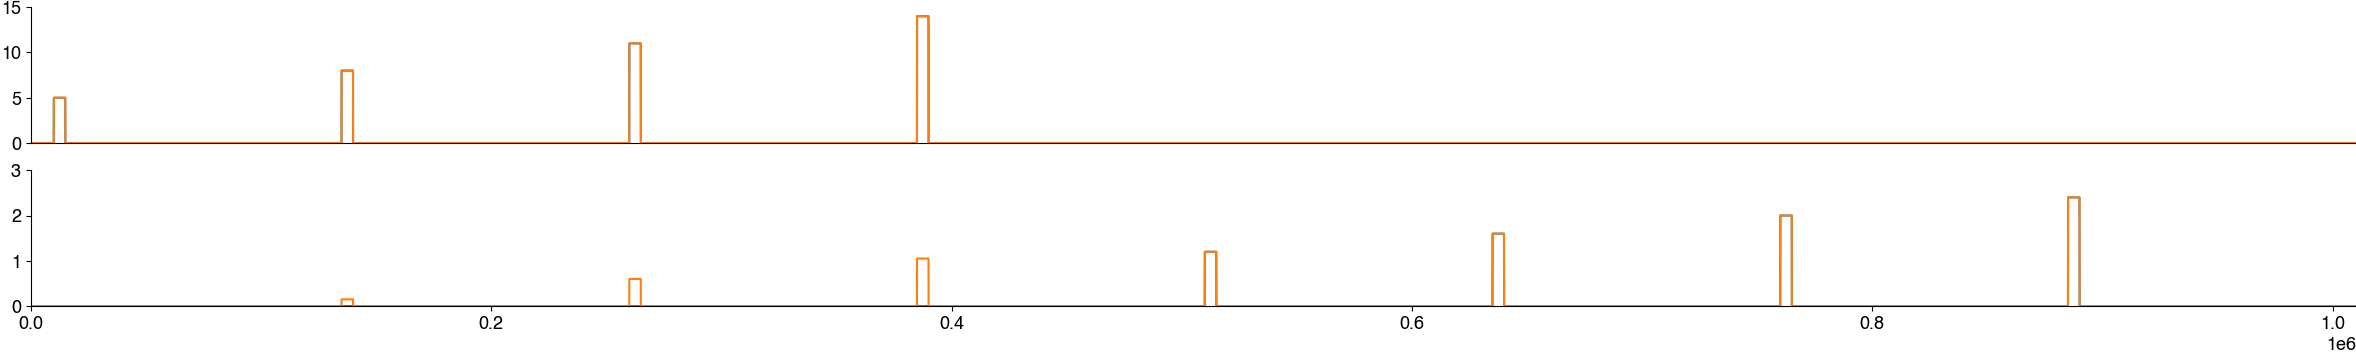

In [5]:
fs = 1_000

pause = np.zeros((120 * fs,))
stim_pC2_1 =  np.concatenate([np.zeros((10 * fs,)), 0.5 * np.ones((5 * fs,)), pause, 0.8 * np.ones((5 * fs,)), pause, 1.1 * np.ones((5 * fs,)), pause, 1.4 * np.ones((5 * fs,)), pause]) * 10
# stim_pC2_1 =  np.concatenate([np.zeros((10 * fs,)), 0.5 * np.ones((5 * fs,)), pause, 0.8 * np.ones((5 * fs,)), pause, 1.1 * np.ones((20 * fs,)), pause, 1.4 * np.ones((5 * fs,)), pause]) * 10
stim_P1_1 = stim_pC2_1 * 0
stim_P1_2 = np.concatenate([ 0.12 * np.ones((5 * fs,)), pause, 0.16 * np.ones((5 * fs,)), pause, 0.20 * np.ones((5 * fs,)), pause, 0.24 * np.ones((5 * fs,)), pause]) * 10
# stim_P1_2 = np.concatenate([ 0.1 * np.ones((5 * fs,)), pause, 0.2 * np.ones((20 * fs,)), pause, 0.4 * np.ones((5 * fs,)), pause, 0.8 * np.ones((5 * fs,)),  pause]) * 10
stim_pC2_2 = stim_P1_2 * 0
stim_pC2 = np.concatenate((stim_pC2_1, stim_pC2_2))
stim_P1 = np.concatenate((stim_P1_1, stim_P1_2))
# stim_pC2[273000:274000] = 20
# stim_pC2[392000:393000] = 20
# stim_pC2[700000:701000] = 20
# stim_P1[700000:700100] = 8

pC2_P1_gain = 0.15 # 0.4
pC2_P1_thres = 7 # 10
# pC2_filter_tau = 200
# pC2_filter = np.exp(np.arange(pC2_filter_tau*10)/-pC2_filter_tau) / np.abs(pC2_filter_tau)
pC2_filter_out = stim_pC2#np.convolve(stim_pC2, pC2_filter, mode='full')[:len(stim_pC2)]

# stim_P1 = np.convolve(stim_P1, pC2_filter, mode='full')[:len(stim_P1)]
P1_filter_out = stim_P1 + np.maximum(pC2_filter_out - pC2_P1_thres, 0) * pC2_P1_gain

plt.figure(figsize=(30, 6))
plt.subplot(311)
plt.plot(stim_pC2)
plt.plot(pC2_filter_out)
plt.xticks([])
plt.ylim(0)

plt.subplot(312)
plt.plot(stim_P1)
plt.plot(P1_filter_out)
plt.ylim(0)
plt.xlim(0, len(stim_P1))
plt.show()

### Short recurrence inside of P1

In [6]:
@numba.jit(nopython=True, fastmath=True, boundscheck=False, cache=True)
def recurrence(stim, stim_gain, rec_gain, rec_tau, rec_pool_gain, rec_pool_tau):
    rec_out = np.zeros_like(stim)
    rec_pool = np.zeros_like(stim)
    for t in range(len(stim)-1):
        rec_out[t+1] = rec_out[t] + (- rec_out[t] + stim[t]*stim_gain + rec_pool[t]*rec_gain) / rec_tau
        rec_pool[t+1] = rec_pool[t] + (-rec_pool[t] + rec_out[t] * rec_pool_gain) / rec_pool_tau
    return rec_out, rec_pool

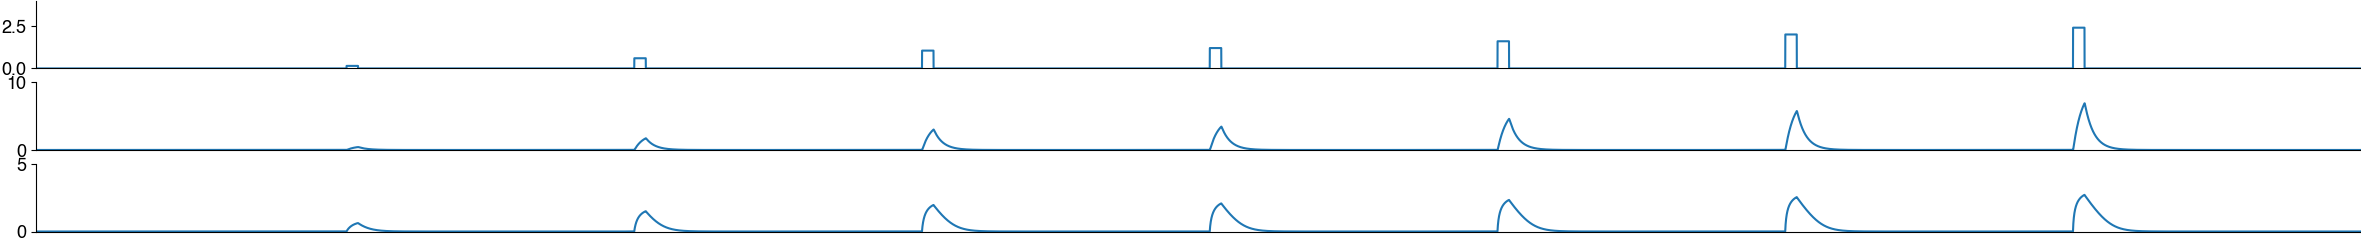

In [7]:
rec_tau = 700
rec_gain = 0.8
stim_gain = 0.8
rec_pool_tau = 100
rec_pool_gain = 1

P1_rec_out, P1_rec_pool = recurrence(P1_filter_out, stim_gain, rec_gain, rec_tau, rec_pool_gain, rec_pool_tau)
P1_rec_out = np.log(1+P1_rec_out * 2)
T = np.arange(len(P1_rec_out)) / fs
plt.figure(figsize=(30, 3))
ax = plt.subplot(311)
plt.plot(T, P1_filter_out)
plt.xticks([])

plt.subplot(312, sharex=ax)
plt.plot(T, P1_rec_pool)
plt.xticks([])

plt.subplot(313, sharex=ax)
plt.plot(T, P1_rec_out)
# ax.set_xlim(380, 480)
plt.show()

### Recurrence downstream of P1

In [8]:
@numba.jit(nopython=True, fastmath=True, boundscheck=False, cache=True)
def recurrence2(stim, stim_tau, stim_gain, rec_gain, rec_tau, rec_pool_gain, rec_pool_tau):
    stim_lp = np.zeros_like(stim)
    rec_out = np.zeros_like(stim)
    rec_pool = np.zeros_like(stim)
    for t in range(len(stim)-1):
        stim_lp[t+1] = stim_lp[t] + (-stim_lp[t] + stim[t]) / stim_tau
        rec_out[t+1] = rec_out[t] + (-rec_out[t] + stim_lp[t]*stim_gain + rec_pool[t]*rec_gain) / rec_tau
        rec_pool[t+1] = rec_pool[t] + (-rec_pool[t] + rec_out[t] * rec_pool_gain) / rec_pool_tau
    return rec_out, rec_pool, stim_lp

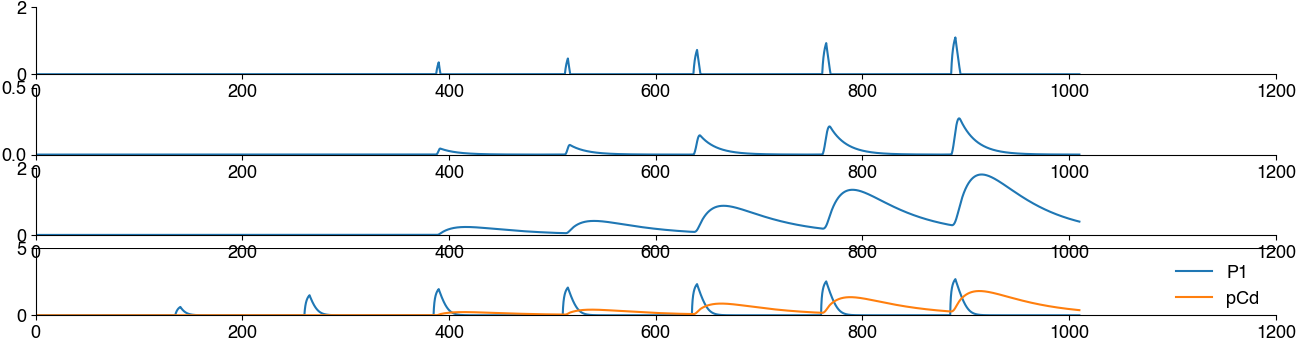

In [9]:
stim_tau = 16000
rec_stim_gain = 1
rec_rec_gain = 0.96
rec_rec_tau = 1
rec_pool_tau = 2000
rec_pool_gain = 1

stim = np.maximum(P1_rec_out-1.6, 0)
rec_out, rec_pool, stim_lp = recurrence2(stim, stim_tau, rec_stim_gain, rec_rec_gain, rec_rec_tau, rec_pool_gain, rec_pool_tau)
T = np.arange(len(rec_out)) / fs
plt.figure(figsize=(16, 4))
ax = plt.subplot(411)
plt.plot(T, stim)
plt.subplot(412, sharex=ax)
plt.plot(T, stim_lp)
plt.subplot(413, sharex=ax)
plt.plot(T, rec_pool)
plt.subplot(414, sharex=ax)
plt.plot(T, P1_rec_out, label='P1')
plt.plot(T, rec_out, label='pCd')
plt.axhline(5, c='k')
plt.legend()
plt.show()

### Mutual inhibition with adapting outputs

[1.6  1.92]


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


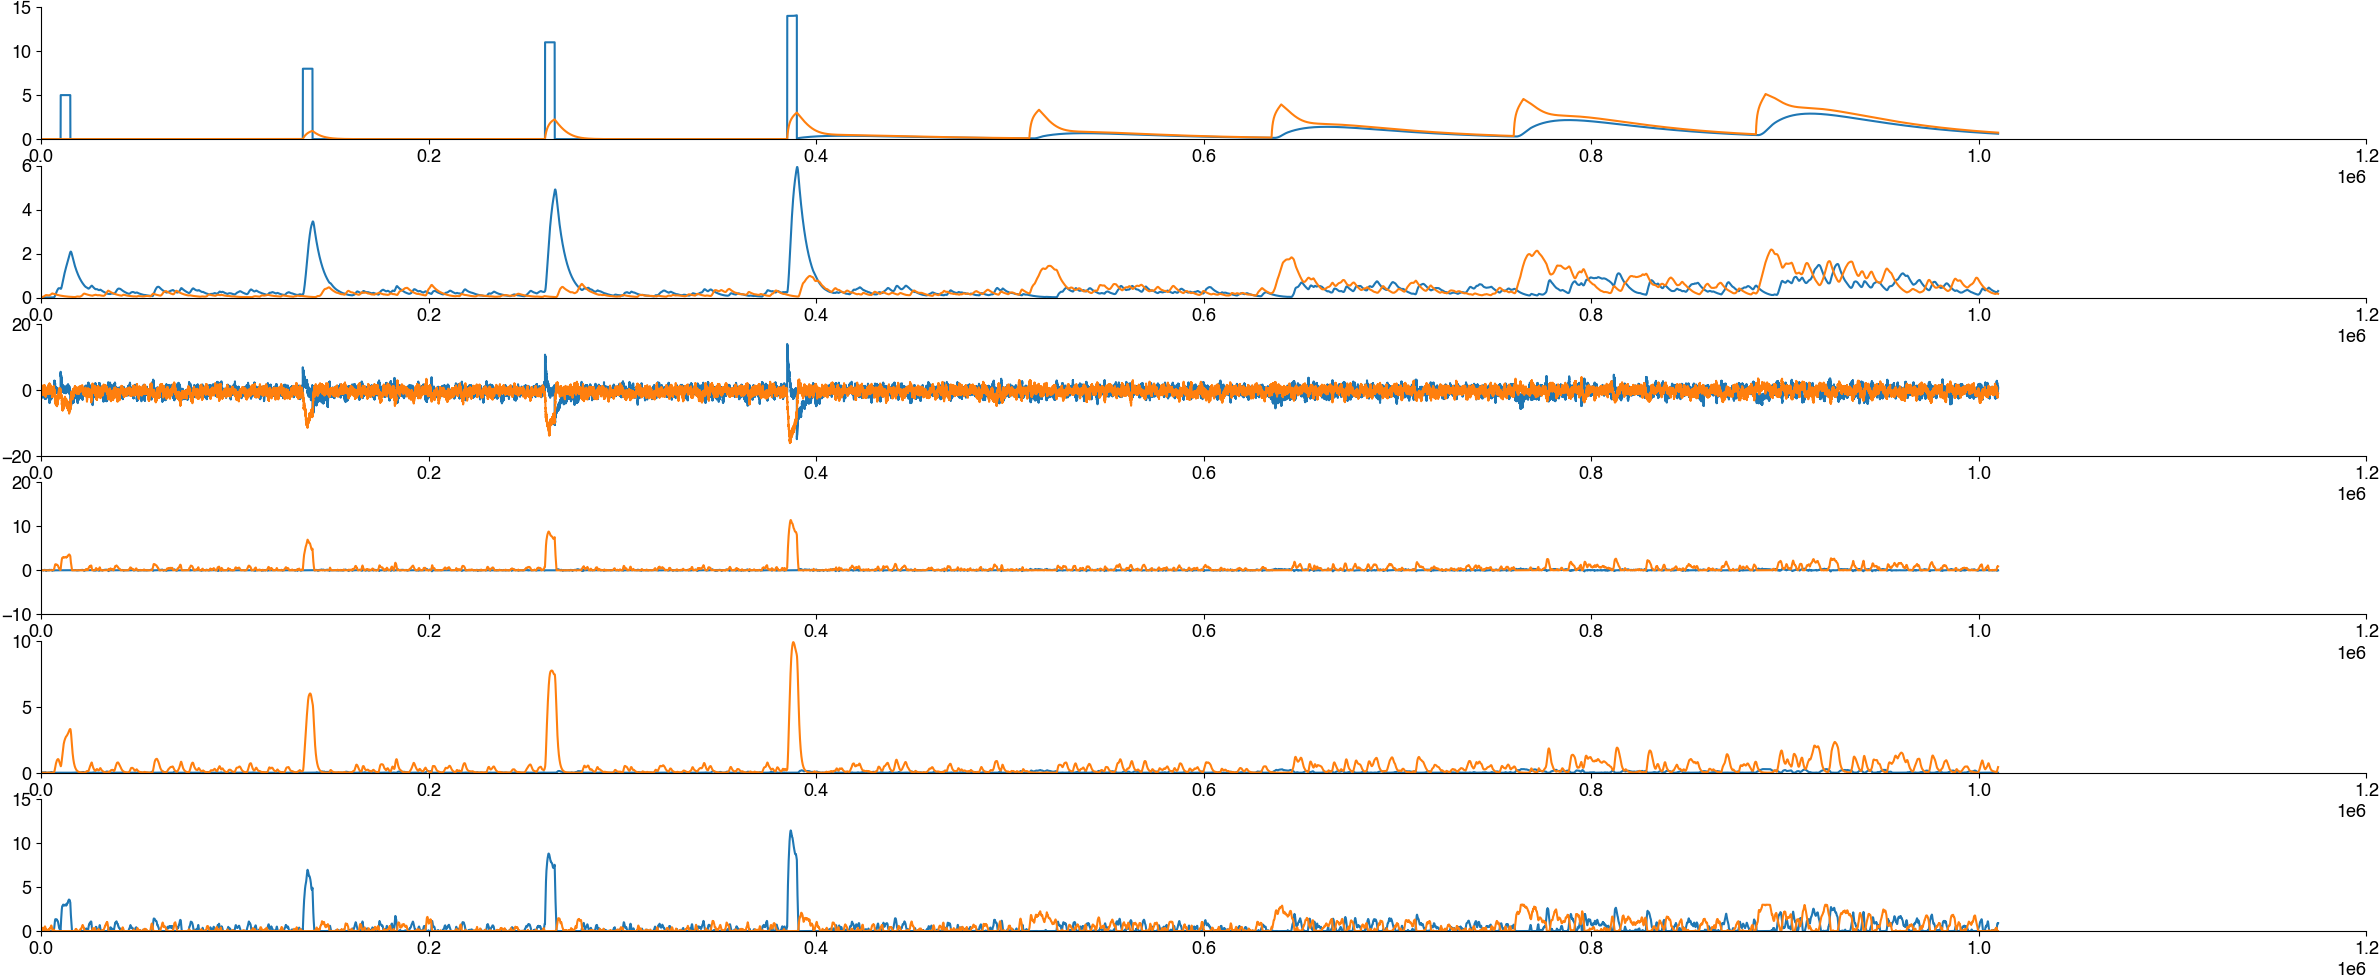

In [10]:
@numba.jit(nopython=True, fastmath=True, boundscheck=False, cache=True)
def mutual_inhibition(stim, mi_tau, mi_mut_gain0, mi_mut_gain1, tau_n, sigma, mi_ada_gain, mi_ada_out_gain, mi_ada_tau):
    out = np.zeros_like(stim)
    ada = np.zeros_like(stim)
    dout_all = np.zeros_like(stim)
    mi = np.zeros_like(stim)
    mi_ada = np.zeros_like(stim)
    n = np.zeros_like(stim)
    N = np.random.randn(*stim.shape)
    mi_ada_mi_gain = 1
    mi_ada_mi_tau = 1000
    mi_mi_ada_gain = [10000, 0]  # only adaptation coming from vibs to song adapts

    for t in range(len(stim)-1):
        n[t+1, :] = n[t] + (-n[t] + sigma * math.sqrt(2 / tau_n) * N[t, :]) / tau_n

        # mutual inhibition neurons
        mi[t+1, 0] = mi[t+1, 0] + (-mi[t, 0] - mi_ada[t, 0] * mi_mi_ada_gain[0] + out[t, 1] / 0.001) / 1000  # from vib to song
        mi[t+1, 1] = mi[t+1, 1] + (-mi[t, 1] - mi_ada[t, 1] * mi_mi_ada_gain[1] + out[t, 0] / 0.001) / 1000  # from song to vib
        mi_ada[t+1] = mi_ada[t] + (-mi_ada[t] + mi[t] * mi_ada_mi_gain) / mi_ada_mi_tau

        # adapt the mutual inhibition
        ada[t+1] = ada[t] + (-ada[t] + out[t] * mi_ada_out_gain) / mi_ada_tau

        dout = -out[t] + stim[t] - ada[t]*mi_ada_gain + n[t]
        dout[0] += -mi[t, 0] * mi_mut_gain0
        dout[1] += -mi[t, 1] * mi_mut_gain1
        # dout[0] += min(-mi[t, 0] * mi_mut_gain0, 0)
        # dout[1] += min(-mi[t, 1] * mi_mut_gain1, 0)

        dout_all[t+1, :] = dout
        out[t+1] = out[t] + dout / mi_tau
        out[t+1,0] = max(out[t+1, 0], 0)
        out[t+1,1] = max(out[t+1, 1], 0)
        out[t+1,0] = min(out[t+1, 0], 20)
        out[t+1,1] = min(out[t+1, 1], 3)
    return stim, ada, out, dout_all, mi, mi_ada

tau_n = 400
sigma = np.array((400, 400))
mi_tau = 1000
mi_mut_gain0 = 10 # vib -> sng
mi_mut_gain1 = 1.5  # sng -> vib
mi_ada_gain = np.array([1, 1])
mi_ada_tau = 5000
mi_ada_out_gain = 1

stim = np.stack((rec_out, rec_out), axis=1) * np.array([2.5, 3]).T * 3.2 / 5 # ['song', 'vibration']
print(np.array([2.5, 3]).T * 3.2 / 5)
stim[:, 0] += pC2_filter_out # song
stim[:, 1] += P1_rec_out * 1.5 # vibration

r = []
for trial in tqdm(np.arange(100)):
    stim, ada, out, dout_all, mi, mi_ada = mutual_inhibition(stim, mi_tau, mi_mut_gain0, mi_mut_gain1, tau_n, sigma, mi_ada_gain, mi_ada_out_gain, mi_ada_tau)
    r.append({'song_input': stim[::10, 0], 'song_ada': ada[::10, 0], 'song_resp': out[::10, 0],
              'mut_inh_to_song': dout_all[::10, 0], 'mut_inh_to_vib': dout_all[::10, 1],
              'vibration_input': stim[::10, 1], 'vibration_ada': ada[::10, 1], 'vibration_resp': out[::10, 1],
              'recurrent_input': P1_rec_out[::10], 'recurrent_pool': rec_pool[::10], 'recurrent_resp': rec_out[::10],
             })

plt.figure(figsize=(30, 12))
plt.subplot(6,1,1)
plt.plot(stim)
plt.subplot(6,1,2)
plt.plot(ada)
plt.subplot(6,1,3)
plt.plot(dout_all)
plt.subplot(6,1,4)
plt.plot(mi)
plt.subplot(6,1,5)
plt.plot(mi_ada)
plt.subplot(6,1,6)
plt.plot(out)
plt.show()

[1.6  1.92]


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


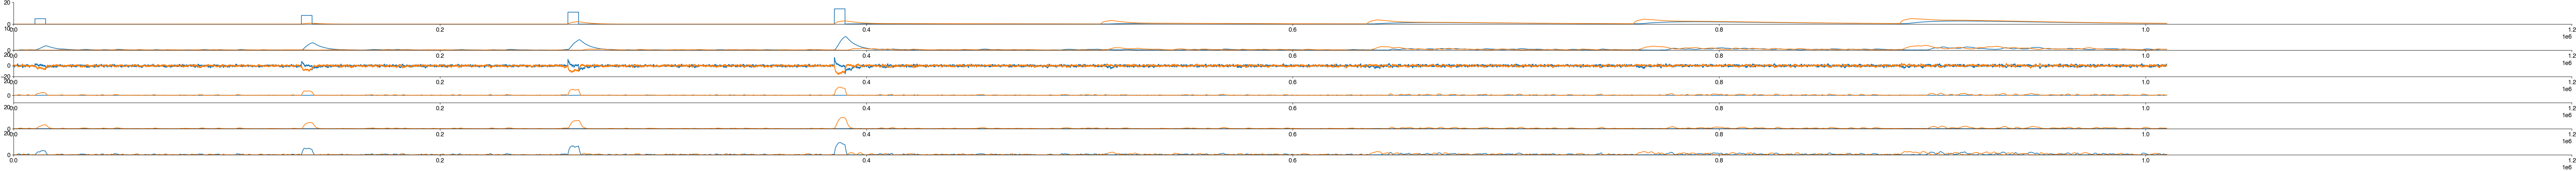

In [11]:
@numba.jit(nopython=True, fastmath=True, boundscheck=False, cache=True)
def mutual_inhibition(stim, mi_tau, mi_mut_gain0, mi_mut_gain1, tau_n, sigma, mi_ada_gain, mi_ada_out_gain, mi_ada_tau):
    out = np.zeros_like(stim)
    ada = np.zeros_like(stim)
    dout_all = np.zeros_like(stim)
    mi = np.zeros_like(stim)
    mi_ada = np.zeros_like(stim)
    n = np.zeros_like(stim)
    N = np.random.randn(*stim.shape)
    mi_ada_mi_gain = 1
    mi_ada_mi_tau = 1000
    mi_mi_ada_gain = [10000, 0]  # only adaptation coming from vibs to song adapts

    for t in range(len(stim)-1):
        n[t+1, :] = n[t] + (-n[t] + sigma * math.sqrt(2 / tau_n) * N[t, :]) / tau_n

        # mutual inhibition neurons
        mi[t+1, 0] = mi[t+1, 0] + (-mi[t, 0] - mi_ada[t, 0] * mi_mi_ada_gain[0] + out[t, 1] / 0.001) / 1000  # from vib to song
        mi[t+1, 1] = mi[t+1, 1] + (-mi[t, 1] - mi_ada[t, 1] * mi_mi_ada_gain[1] + out[t, 0] / 0.001) / 1000  # from song to vib
        mi_ada[t+1] = mi_ada[t] + (-mi_ada[t] + mi[t] * mi_ada_mi_gain) / mi_ada_mi_tau

        # output adaptation
        ada[t+1] = ada[t] + (-ada[t] + out[t] * mi_ada_out_gain) / mi_ada_tau

        dout = -out[t] + stim[t] - ada[t]*mi_ada_gain + n[t]
        dout[0] += -mi[t, 0] * mi_mut_gain0
        dout[1] += -mi[t, 1] * mi_mut_gain1
        # dout[0] += min(-mi[t, 0] * mi_mut_gain0, 0)
        # dout[1] += min(-mi[t, 1] * mi_mut_gain1, 0)

        dout_all[t+1, :] = dout
        out[t+1] = out[t] + dout / mi_tau
        out[t+1,0] = max(out[t+1, 0], 0)
        out[t+1,1] = max(out[t+1, 1], 0)
        out[t+1,0] = min(out[t+1, 0], 20)
        out[t+1,1] = min(out[t+1, 1], 3)
    return stim, ada, out, dout_all, mi, mi_ada

tau_n = 400
sigma = np.array((400, 400))
mi_tau = 1000
mi_mut_gain0 = 10 # vib -> sng
mi_mut_gain1 = 1.5  # sng -> vib
mi_ada_gain = np.array([1, 1])
mi_ada_tau = 5000
mi_ada_out_gain = 1

stim = np.stack((rec_out, rec_out), axis=1) * np.array([2.5, 3]).T * 3.2 / 5 # ['song', 'vibration']
print(np.array([2.5, 3]).T * 3.2 / 5)
stim[:, 0] += pC2_filter_out # song
stim[:, 1] += P1_rec_out * 1.5 # vibration

r = []
for trial in tqdm(np.arange(20)):
    stim, ada, out, dout_all, mi, mi_ada = mutual_inhibition(stim, mi_tau, mi_mut_gain0, mi_mut_gain1, tau_n, sigma, mi_ada_gain, mi_ada_out_gain, mi_ada_tau)
    r.append({'song_input': stim[::10, 0], 'song_ada': ada[::10, 0], 'song_resp': out[::10, 0],
              'mut_inh_to_song': dout_all[::10, 0], 'mut_inh_to_vib': dout_all[::10, 1], 'mi': mi,
              'vibration_input': stim[::10, 1], 'vibration_ada': ada[::10, 1], 'vibration_resp': out[::10, 1],
              'recurrent_input': P1_rec_out[::10], 'recurrent_pool': rec_pool[::10], 'recurrent_resp': rec_out[::10],
             })

plt.figure(figsize=(100, 6))
plt.subplot(6,1,1)
plt.plot(stim)
plt.subplot(6,1,2)
plt.plot(ada)
plt.subplot(6,1,3)
plt.plot(dout_all)
plt.subplot(6,1,4)
plt.plot(mi)
plt.subplot(6,1,5)
plt.plot(mi_ada)
plt.subplot(6,1,6)
plt.plot(out)
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


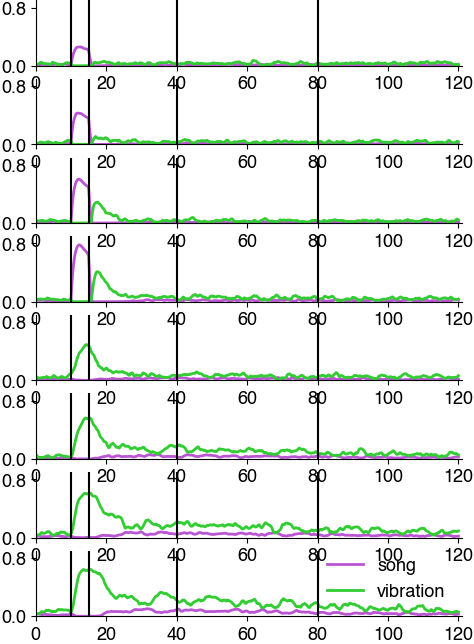

In [15]:
s = []
v = []
si = []
vi = []
sa = []
va = []
sm = []
vm = []
mi = []
for rr in r:
    s.append(rr['song_resp'])
    v.append(rr['vibration_resp'])
    si.append(rr['song_input'])
    vi.append(rr['vibration_input'])
    sa.append(rr['song_ada'])
    va.append(rr['vibration_ada'])
    sm.append(rr['mut_inh_to_song'])
    vm.append(rr['mut_inh_to_vib'])
    mi.append(rr['mi'])

si = np.stack(si, axis=-1)
vi = np.stack(vi, axis=-1)
sa = np.stack(sa, axis=-1)
va = np.stack(va, axis=-1)
sm = np.stack(sm, axis=-1)
vm = np.stack(vm, axis=-1)
mi = np.stack(mi, axis=-1)

s = np.clip(np.stack(s, axis=-1) / 14, 0, 1)  # np.clip(np.stack(s, axis=-1), 0, 7 * 3) /10 / 3
v = np.clip(np.stack(v, axis=-1) / 4.5, 0, 1) # np.clip(np.stack(v, axis=-1), 0, 4) / 6
T = np.arange(s.shape[0]) / fs
wta = np.argmax(np.stack((np.zeros_like(s), s, v)), axis=0)
np.savez_compressed('res/demo.npz', most_likely_signal=wta, trials_rate_song=s, trials_rate_vibration=v, time=T, stim_P1=stim_P1[::10], stim_pC2=stim_pC2[::10], recurrent_input=P1_rec_out[::10], recurrent_pool=rec_pool[::10], recurrent_resp=rec_out[::10],
                                             song_input=si, vibration_input=vi, song_ada=sa, vibration_ada=va, mut_inh_to_song_old=sm, mut_inh_to_vib_old=vm, mut_inh_to_song=mi[::10, 0, :], mut_inh_to_vib=mi[::10, 1, :])
d = np.load('res/demo.npz')

t0 = 0
dur = 120
ivl = 125
T = np.arange(0, dur, 1/(fs/10))
plt.figure(figsize=(5.5, 8))
for ii in range(8):
    plt.subplot(8, 1, ii+1)
    i0 = int((t0 + ivl * ii) * fs / 10)
    i1 = int(i0 + dur * fs / 10)

    plt.plot(T, np.mean(d['trials_rate_song'], axis=1)[i0:i1], label='song', c='mediumorchid', linewidth=2)
    plt.plot(T, np.mean(d['trials_rate_vibration'], axis=1)[i0:i1], label='vibration', c='limegreen', linewidth=2)
    plt.ylim(0, 0.9)
    plt.yticks((0, 0.8))
    plt.xlim(T[0], T[-1]+1)
    [plt.axvline(tt, c='k') for tt in [10, 15, 40, 80]]
plt.legend()
plt.savefig('fig/dose_response.pdf')
plt.show()